In [1]:
import geopandas as gpd
import pandas as pd

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

**CONTENIDO**

- Cargar data CS
- Resultados Complejos observables en CS
- Procesamiento para datasets geograficos
    - Mapas Ejemplo (Base Personas)
    - Comandos Mapbox CLI

# Cargar data CS

### Precios Corrientes

In [2]:
from datetime import datetime
# hoy = datetime.today().strftime('%Y-%m-%d')

cpi = pd.read_csv('https://raw.githubusercontent.com/matuteiglesias/IPC-Argentina/main/data/info/indice_precios_M.csv', index_col=0)
cpi.index = pd.to_datetime(cpi.index)


hoy = datetime.today().strftime('%Y-%m')

# Ratio de precios de hoy con respecto a precios con indice en base modelo
ix = cpi.loc[hoy]['index'].values[0]/cpi.loc['2016-01']['index'].values[0]
# ix = cpi.loc['2020-09-30'].values[0]/cpi.loc['2016-01-01'].values[0] # Precios del periodo en estudio

columnas_pesos =  ['P47T_persona', 'P47T_hogar', 'CBA', 'gap_indigencia', 'CBT', 'gap_pobreza']

### Leer data CS

In [3]:
data = pd.read_csv('/media/miglesia/Elements/suite/indice-pobreza-ExactasUBA/data/Pobreza/pobreza_0.02_ARGCSactual.csv', encoding_errors='ignore')

## Deflacta a precios actuales
data[columnas_pesos] = ix*data[columnas_pesos]

### Unir NOMDPTO y Region

In [4]:
frac = 0.02
# data = pd.read_csv('./../data/Pobreza/pobreza_'+str(frac)+'_2020.csv')
# /media/miglesia/Elements/suite/indice-pobreza-ExactasUBA/data/Pobreza/pobreza_0.01_2021-2022.csv saved

radio_ref = pd.read_csv('./../data/info/radio_ref.csv')
radio_ref['COD_2010'] = radio_ref['radio'].astype(str).str.zfill(9)
dpto_region = pd.read_csv('./../data/info/DPTO_PROV_Region.csv')
radio_ref = radio_ref.merge(dpto_region)
aglo_labels = pd.read_csv('./../data/info/aglo_labels.csv')[['AGLOMERADO', 'NOMAGLO']]
radio_ref = radio_ref[['RADIO_REF_ID', 'COD_2010', 'NOMDPTO', 'AGLOMERADO', 'Region']].drop_duplicates().merge(aglo_labels)


data = data.merge(radio_ref, on = ['RADIO_REF_ID', 'AGLOMERADO'])
data['AGLO_si'] = data.AGLOMERADO != 0

# Resultados Complejos observables en CS

In [5]:
table = 100*data.groupby('NOMAGLO')[['Pobreza', 'Indigencia']].mean().round(3)
table.sort_values('Indigencia')

,Pobreza,Indigencia
NOMAGLO,,
CABA,13.0,3.5
Ushuaia-Rio Grande,22.5,3.5
Viedma-Patagones,28.7,4.5
Rio Gallegos,26.5,5.3
Neuquen,28.8,5.5
Cdro Rivadavia,32.2,5.6
Bahia Blanca,27.5,6.4
Rawson-Trelew,30.5,6.6
La Plata,28.8,6.6


# Procesamiento para datasets geograficos

### Synthetizer functions

In [6]:
### Sintetizadores
import datetime as dt
import numpy as np

## Base Personas
def sintetizar_P(data, grouper, frac = 0.02):
    df = data.copy()
    df['Total'] = True
    df['timestamp'] = dt.datetime.today()
    n_Qs = df.Q.nunique()
    
#     # Funciones percentil
#     percentiles = [.10, .25, .75, .9, .2]
#     quantile_funcs = [(p, lambda x: x.quantile(p)) for p in percentiles]

    df = df.groupby(grouper + ['timestamp'])[['Total', 'Pobreza', 'Indigencia','P47T_persona'#, 'Pobreza_5usd'
                                             ]].agg(
        {'Total': ['mean', 'sum'], 'Pobreza': ['mean', 'sum'], 'Indigencia': ['mean', 'sum'], #'Pobreza_5usd': ['mean', 'sum'], 
         'P47T_persona':['mean', q10, q25, 'median', q75, q90]})
    
    df[[('Total', 'sum')]] = (df[[('Total', 'sum')]]/frac).round(1)#.astype(int)
    df[[('Pobreza', 'sum')]] = (df[[('Pobreza', 'sum')]]/frac).round(1)#.astype(int)
    df[[('Indigencia', 'sum')]] = (df[[('Indigencia', 'sum')]]/frac).round(1)#.astype(int)
#     df[[('Pobreza_5usd', 'sum')]] = (df[[('Pobreza_5usd', 'sum')]]/frac).round(1)#.astype(int)
    df[[('Total', 'mean')]] = df[[('Total', 'mean')]].round(4)
    df[[('Indigencia', 'mean')]] = df[[('Indigencia', 'mean')]].round(4)
    df[[('Pobreza', 'mean')]] = df[[('Pobreza', 'mean')]].round(4)
#     df[[('Pobreza_5usd', 'mean')]] = df[[('Pobreza_5usd', 'mean')]].round(4)
    
    df['P47T_persona'] = df['P47T_persona'].round(-1).astype(int)
    
    dfB = df.T.set_index(np.repeat('Personas', df.shape[1]), append=True)
       
#     dfB = dfB.stack().stack().stack().reset_index()
    stacker_ix = [-i for i in range(len(grouper) + 1)]
    dfB = dfB.stack(level = stacker_ix).reset_index()
    
    dfB = dfB.rename(columns = {'level_0': 'observable', 'level_1': 'sintetico', 'level_2': 'base', 0: 'valor'})
    dfB['valor'] = dfB['valor'].astype(float)
    return dfB

def sintetizar_H(data, grouper, frac = 0.02):
    df = data.copy()
    df = df.groupby('HOGAR_REF_ID').first()
    df['Total'] = True
    df['timestamp'] = dt.datetime.today()
    n_Qs = df.Q.nunique()

#     # Funciones percentil
#     percentiles = [.10, .25, .75, .9, .2]
#     quantile_funcs = [(p, lambda x: x.quantile(p)) for p in percentiles]

    df = df.groupby(grouper + ['timestamp'])[['Total', 'Pobreza', 'Indigencia', 'P47T_hogar', 'CB_EQUIV', 'CBA', #'Pobreza_5usd',
                                              'gap_indigencia', 'CBT', 'gap_pobreza']
                            ].agg(
    {'Total': ['mean', 'sum'], 'Pobreza': ['mean', 'sum'], 'Indigencia': ['mean', 'sum'], #'Pobreza_5usd': ['mean', 'sum'], 
     'P47T_hogar': ['mean', q10, q25, 'median', q75, q90],
     'CB_EQUIV': ['mean', 'median'],     
     'CBA': ['sum', 'median'], 'gap_indigencia': ['mean', 'median'], 
     'CBT': ['sum', 'median'], 'gap_pobreza': ['mean', 'median']})
        
    df[[('Total', 'sum')]] = (df[[('Total', 'sum')]]/frac/n_Qs).round(1)#.astype(int)
    df[[('Pobreza', 'sum')]] = (df[[('Pobreza', 'sum')]]/frac/n_Qs).round(1)#.astype(int)
    df[[('Indigencia', 'sum')]] = (df[[('Indigencia', 'sum')]]/frac/n_Qs).round(1)#.astype(int)
#     df[[('Pobreza_5usd', 'sum')]] = (df[[('Pobreza_5usd', 'sum')]]/frac).round(1)#.astype(int)
    df[[('Total', 'mean')]] = df[[('Total', 'mean')]].round(4)
    df[[('Pobreza', 'mean')]] = df[[('Pobreza', 'mean')]].round(4)
    df[[('Indigencia', 'mean')]] = df[[('Indigencia', 'mean')]].round(4)
#     df[[('Pobreza_5usd', 'mean')]] = (df[[('Pobreza_5usd', 'mean')]]/frac).round(1)#.astype(int)

    df['CB_EQUIV'] = df['CB_EQUIV'].round(4)
    
    df['P47T_hogar'] = df['P47T_hogar'].round(-1).astype(int)
    df['CBA'] = df['CBA'].round(-1).astype(int)
    df['gap_indigencia'] = df['gap_indigencia'].round(-1).astype(int)
    df['CBT'] = df['CBT'].round(-1).astype(int)
    df['gap_pobreza'] = df['gap_pobreza'].round(-1).astype(int)
    
    dfC = df.T.set_index(np.repeat('Hogares', df.shape[1]), append=True)
    dfC.index.names = ['observable', 'sintetico', 'base']
    
#     FrozenList(['observable', 'sintetico', 'base', 'timestamp', 'AGLOMERADO', 'Region', 'Q'])
    
# #     dfC = dfC.stack().stack().stack().reset_index()
    stacker_ix = [-i for i in range(len(grouper) + 1)]
    dfC = dfC.stack(level = stacker_ix).reset_index()
#     # es como df.stack([-1, -2, -3, -4]) pero se adapta a groupers mas o menos largos
#     dfC = dfC.stack(stacker_ix).reset_index()

    dfC = dfC.rename(columns = {'level_0': 'observable', 'level_1': 'sintetico', 'level_2': 'base', 0: 'valor'})
    dfC['valor'] = dfC['valor'].astype(float)
    return dfC

# Percentile funcs
def q10(x):
    return x.quantile(0.1)

def q25(x):
    return x.quantile(0.25)

def q75(x):
    return x.quantile(0.75)

def q90(x):
    return x.quantile(0.9)

In [7]:
x = sintetizar_P(data, ['PROV'], frac = 0.02)
x.groupby(['observable','sintetico','base']).size()

observable    sintetico  base    
Indigencia    mean       Personas    24
              sum        Personas    24
P47T_persona  mean       Personas    24
              median     Personas    24
              q10        Personas    24
              q25        Personas    24
              q75        Personas    24
              q90        Personas    24
Pobreza       mean       Personas    24
              sum        Personas    24
Total         mean       Personas    24
              sum        Personas    24
dtype: int64

In [8]:
# sintetizar_H(data, ['PROV'], frac = 0.02).groupby(['observable','sintetico','base']).size()

In [9]:
# # Ej. Personas en pobreza
# # df = sintetizar_P(data, ['PROV'], frac = 0.02)
# # df.loc[df.sintetico == 'sum'].groupby('observable')['valor'].sum() 

# Indigencia     6500687.5
# Pobreza       21147900.0
# Total         44603650.0

## Los niveles geograficos disponibles son:
 - Radios (RADIO_REF_ID)
 - Fracciones (IDFRAC, no es clave unica)
 - Dptos (DPTO)
 - Provs (PROV)
 - Aglos (AGLOMERADO)
 - (Region)

### Cargar geometrias

In [10]:
## RADIO REF. Referencia de radios censales segun Censo 2010

# radio_ref = pd.read_csv('./radio_ref.csv')
# radio_ref['DPTO'] = radio_ref['DPTO'].astype(int)
# radio_ref['COD_2010'] = radio_ref['radio'].astype(str).str.zfill(9)

## POLIGONOS
# admin410_f = './../../IGN_INDEC_georef/censos_shp_CONICET/2010_RADIOS ARGENTINA'
admin310_f = './../../IGN_INDEC_georef/censos_shp_CONICET_dissolved/fracs_2010.shp'
admin210_f = './../../IGN_INDEC_georef/censos_shp_CONICET_dissolved/dptos_2010.shp'
admin1_f = './../../IGN_INDEC_georef/IGN_shp/Provincia/'

## Provincias del IGN
admin1 = gpd.read_file(admin1_f)  # COD_2010 = '020130302'
# admin1['ID'] = admin1.IN1 + '0000000'
admin1['PROV'] = admin1.IN1.astype(int)
admin1 = admin1[['PROV', 'geometry']]

### Poligonos de censo de CONICET.
# admin410 = gpd.read_file(admin410_f)  # COD_2010 = '020130302'
# admin410['ID'] = admin410['COD_2010']

admin310 = gpd.read_file(admin310_f)  
admin310['IDFRAC'] = admin310.PROV_ + admin310.DEPTO_ + admin310.FRACC_ + '00'
admin310 = admin310[['IDFRAC', 'geometry']]

admin210 = gpd.read_file(admin210_f) 
# admin210['ID'] = admin210.PROV_ + admin210.DEPTO_ + '0000'
admin210['DPTO'] = (admin210['PROV_'] + admin210['DEPTO_']).astype(int)
admin210 = admin210[['DPTO', 'geometry']]


## ADOPTAR CRS del IGN
admin210 = admin210.to_crs(admin1.crs)
admin310 = admin310.to_crs(admin1.crs)

In [11]:
admin1['area_km2'] = admin1['geometry'].to_crs('epsg:3395').map(lambda p: p.area / 10**6)
admin210['area_km2'] = admin210['geometry'].to_crs('epsg:3395').map(lambda p: p.area / 10**6)
admin310['area_km2'] = admin310['geometry'].to_crs('epsg:3395').map(lambda p: p.area / 10**6)

In [12]:
admin310.head()

,IDFRAC,geometry,area_km2
0,020010100,"POLYGON ((-58.37431 -34.57871, -58.37431 -34.5...",2.663001
1,020010200,"POLYGON ((-58.37567 -34.58419, -58.37552 -34.5...",0.627842
2,020010300,"POLYGON ((-58.38788 -34.58285, -58.38788 -34.5...",1.302769
3,020010400,"POLYGON ((-58.38650 -34.59284, -58.38650 -34.5...",0.299640
4,020010500,"POLYGON ((-58.38161 -34.59284, -58.38161 -34.5...",0.294890


### Funcion guardar geojson

In [13]:
import os
# pip install geopandas
import geopandas as gpd


def save_geojson(gdf, filename = 'test.geojson'):
    if not os.path.exists('./../data/geojson/'):
        os.makedirs('./../data/geojson/')
    
    try:    # Delete if geojson exists, cause overwriting is not supported
        os.remove('./../data/geojson/'+filename)
    except OSError:
        pass
    
    gdf.to_file('./../data/geojson/'+filename, driver="GeoJSON", encoding='utf-8')


In [14]:
# # Las variables agrupadoras pueden ser: 
# groupers = [['Q','Total_pais'], ['Q','AGLOMERADO'], ['Q','Region'], 
#             ['Q','PROV'], ['Q','DPTO']]

## Base: Personas

In [15]:
## PROVINCIAS

df = sintetizar_P(data, ['PROV'], frac = 0.02).drop('timestamp', axis = 1)#.groupby(['observable','sintetico','base']).size()
df = df.set_index(list(df.drop('valor', 1).columns)).unstack([0, 1])['valor']
df.columns = ['_'.join(col) for col in df.columns.values]
df = df.reset_index()

gdf = gpd.GeoDataFrame(df.merge(admin1), crs = admin1.crs)

save_geojson(gdf, filename = 'pobreza_P_PROV.geojson')

<ipython-input-15-f560e0eea319>:4: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df = df.set_index(list(df.drop('valor', 1).columns)).unstack([0, 1])['valor']
/home/miglesia/anaconda3/lib/python3.8/site-packages/geopandas/io/file.py:234: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


In [16]:
## DPTOS
df = sintetizar_P(data, ['DPTO'], frac = 0.02).drop('timestamp', axis = 1)#.groupby(['observable','sintetico','base']).size()
df = df.set_index(list(df.drop('valor', 1).columns)).unstack([0, 1])['valor']
df.columns = ['_'.join(col) for col in df.columns.values]
df = df.reset_index()

gdf = gpd.GeoDataFrame(df.merge(admin210), crs = admin210.crs)

save_geojson(gdf, filename = 'pobreza_P_DPTO.geojson')

<ipython-input-16-521b0bda4aaa>:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df = df.set_index(list(df.drop('valor', 1).columns)).unstack([0, 1])['valor']
/home/miglesia/anaconda3/lib/python3.8/site-packages/geopandas/io/file.py:234: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


<AxesSubplot:>

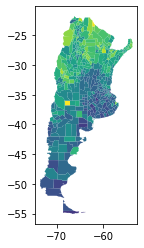

In [17]:
gdf.plot('Pobreza_mean')

In [18]:
## FRACS
data['IDFRAC'] = data['COD_2010'].str[:-2] + '00'
df = sintetizar_P(data, ['IDFRAC'], frac = 0.02).drop('timestamp', axis = 1)#.groupby(['observable','sintetico','base']).size()

df = df.set_index(list(df.drop('valor', 1).columns)).unstack([0, 1])['valor']
df.columns = ['_'.join(col) for col in df.columns.values]
df = df.reset_index()

gdf = gpd.GeoDataFrame(df.merge(admin310), crs = admin310.crs)

save_geojson(gdf, filename = 'pobreza_P_FRAC.geojson')

In [19]:
# gdf = gpd.read_file('./../data/geojson/pobreza_P_FRAC.geojson'); gdf = gdf.loc[gdf.PROV.isin(['02', '06'])]

## Base: Personas, Mayores de 24.

In [ ]:
## PROVINCIAS

df = sintetizar_P(data.loc[data.P03 >= 24], ['PROV'], frac = 0.02).drop('timestamp', axis = 1)#.groupby(['observable','sintetico','base']).size()
df = df.set_index(list(df.drop('valor', 1).columns)).unstack([0, 1])['valor']
df.columns = ['_'.join(col) for col in df.columns.values]
df = df.reset_index()

gdf = gpd.GeoDataFrame(df.merge(admin1), crs = admin1.crs)

save_geojson(gdf, filename = 'pobreza_M24_PROV.geojson')

In [ ]:
gdf.head(1)

In [ ]:
## DPTOS
df = sintetizar_P(data.loc[data.P03 >= 24], ['DPTO'], frac = 0.02).drop('timestamp', axis = 1)#.groupby(['observable','sintetico','base']).size()
df = df.set_index(list(df.drop('valor', 1).columns)).unstack([0, 1])['valor']
df.columns = ['_'.join(col) for col in df.columns.values]
df = df.reset_index()

gdf = gpd.GeoDataFrame(df.merge(admin210), crs = admin210.crs)

save_geojson(gdf, filename = 'pobreza_M24_DPTO.geojson')

In [ ]:
gdf.head(1)

In [ ]:
## FRACS
data['IDFRAC'] = data['COD_2010'].str[:-2] + '00'
df = sintetizar_P(data.loc[data.P03 >= 24], ['IDFRAC'], frac = 0.02).drop('timestamp', axis = 1)#.groupby(['observable','sintetico','base']).size()

df = df.set_index(list(df.drop('valor', 1).columns)).unstack([0, 1])['valor']
df.columns = ['_'.join(col) for col in df.columns.values]
df = df.reset_index()

gdf = gpd.GeoDataFrame(df.merge(admin310), crs = admin310.crs)

save_geojson(gdf, filename = 'pobreza_M24_FRAC.geojson')

## Base: Personas, Menores de 14.

In [ ]:
## PROVINCIAS

df = sintetizar_P(data.loc[data.P03 <= 14], ['PROV'], frac = 0.02).drop('timestamp', axis = 1)#.groupby(['observable','sintetico','base']).size()
df = df.set_index(list(df.drop('valor', 1).columns)).unstack([0, 1])['valor']
df.columns = ['_'.join(col) for col in df.columns.values]
df = df.reset_index()

gdf = gpd.GeoDataFrame(df.merge(admin1), crs = admin1.crs)

save_geojson(gdf, filename = 'pobreza_M14_PROV.geojson')

In [ ]:
gdf.head(1)

In [ ]:
## DPTOS
df = sintetizar_P(data.loc[data.P03 <= 14], ['DPTO'], frac = 0.02).drop('timestamp', axis = 1)#.groupby(['observable','sintetico','base']).size()
df = df.set_index(list(df.drop('valor', 1).columns)).unstack([0, 1])['valor']
df.columns = ['_'.join(col) for col in df.columns.values]
df = df.reset_index()

gdf = gpd.GeoDataFrame(df.merge(admin210), crs = admin210.crs)

save_geojson(gdf, filename = 'pobreza_M14_DPTO.geojson')

In [ ]:
gdf.head(1)

In [ ]:
## FRACS
data['IDFRAC'] = data['COD_2010'].str[:-2] + '00'
df = sintetizar_P(data.loc[data.P03 <= 14], ['IDFRAC'], frac = 0.02).drop('timestamp', axis = 1)#.groupby(['observable','sintetico','base']).size()

df = df.set_index(list(df.drop('valor', 1).columns)).unstack([0, 1])['valor']
df.columns = ['_'.join(col) for col in df.columns.values]
df = df.reset_index()

gdf = gpd.GeoDataFrame(df.merge(admin310), crs = admin310.crs)

save_geojson(gdf, filename = 'pobreza_M14_FRAC.geojson')

## Base: Personas, Menores de 6.

In [ ]:
## PROVINCIAS

df = sintetizar_P(data.loc[data.P03 <= 6], ['PROV'], frac = 0.02).drop('timestamp', axis = 1)#.groupby(['observable','sintetico','base']).size()
df = df.set_index(list(df.drop('valor', 1).columns)).unstack([0, 1])['valor']
df.columns = ['_'.join(col) for col in df.columns.values]
df = df.reset_index()

gdf = gpd.GeoDataFrame(df.merge(admin1), crs = admin1.crs)

save_geojson(gdf, filename = 'pobreza_M6_PROV.geojson')

In [ ]:
gdf.head(1)

In [ ]:
## DPTOS
df = sintetizar_P(data.loc[data.P03 <= 6], ['DPTO'], frac = 0.02).drop('timestamp', axis = 1)#.groupby(['observable','sintetico','base']).size()
df = df.set_index(list(df.drop('valor', 1).columns)).unstack([0, 1])['valor']
df.columns = ['_'.join(col) for col in df.columns.values]
df = df.reset_index()

gdf = gpd.GeoDataFrame(df.merge(admin210), crs = admin210.crs)

save_geojson(gdf, filename = 'pobreza_M6_DPTO.geojson')

In [ ]:
gdf.head(1)

In [ ]:
## FRACS
data['IDFRAC'] = data['COD_2010'].str[:-2] + '00'
df = sintetizar_P(data.loc[data.P03 <= 6], ['IDFRAC'], frac = 0.02).drop('timestamp', axis = 1)#.groupby(['observable','sintetico','base']).size()

df = df.set_index(list(df.drop('valor', 1).columns)).unstack([0, 1])['valor']
df.columns = ['_'.join(col) for col in df.columns.values]
df = df.reset_index()

gdf = gpd.GeoDataFrame(df.merge(admin310), crs = admin310.crs)

save_geojson(gdf, filename = 'pobreza_M6_FRAC.geojson')

## Base: Hogares

In [ ]:
## PROVINCIAS

df = sintetizar_H(data, ['PROV'], frac = 0.02).drop('timestamp', axis = 1)#.groupby(['observable','sintetico','base']).size()
df = df.set_index(list(df.drop('valor', 1).columns)).unstack([0, 1])['valor']
df.columns = ['_'.join(col) for col in df.columns.values]
df = df.reset_index()

gdf = gpd.GeoDataFrame(df.merge(admin1), crs = admin1.crs)

save_geojson(gdf, filename = 'pobreza_H_PROV.geojson')

In [ ]:
gdf.head(1)

In [ ]:
## DPTOS
df = sintetizar_H(data, ['DPTO'], frac = 0.02).drop('timestamp', axis = 1)#.groupby(['observable','sintetico','base']).size()
df = df.set_index(list(df.drop('valor', 1).columns)).unstack([0, 1])['valor']
df.columns = ['_'.join(col) for col in df.columns.values]
df = df.reset_index()

gdf = gpd.GeoDataFrame(df.merge(admin210), crs = admin210.crs)

save_geojson(gdf, filename = 'pobreza_H_DPTO.geojson')

In [ ]:
gdf.head(1)

In [ ]:
## FRACS
data['IDFRAC'] = data['COD_2010'].str[:-2] + '00'
df = sintetizar_H(data, ['IDFRAC'], frac = 0.02).drop('timestamp', axis = 1)#.groupby(['observable','sintetico','base']).size()

df = df.set_index(list(df.drop('valor', 1).columns)).unstack([0, 1])['valor']
df.columns = ['_'.join(col) for col in df.columns.values]
df = df.reset_index()

gdf = gpd.GeoDataFrame(df.merge(admin310), crs = admin310.crs)

save_geojson(gdf, filename = 'pobreza_H_FRAC.geojson')

In [ ]:
xx

## Comandos Mapbox CLI

In [ ]:
## Repetir para Hogares, para M24, M14, etc.

## Atenti, mandarlo a disco duro, no a drive

In [ ]:
cd /media/miglesia/Elements/suite/indice-pobreza-ExactasUBA/data
export MAPBOX_ACCESS_TOKEN=sk.eyJ1IjoibWF0dXRlaWdsZXNpYXMyIiwiYSI6ImNrb3lvMWZyajAxZncycG8ycnJkaTI1ZjYifQ.LXJGImmBgQtWWrNOC1wTcA

In [ ]:
tilesets delete-source -f matuteiglesias2 income_provs_H
tilesets delete-source -f matuteiglesias2 income_dptos_H
tilesets delete-source -f matuteiglesias2 income_fracs_H

tilesets delete -f matuteiglesias2.income_H

## HOGARES. 
# (REPEAT FOR PERSONAS, M24, ETC.)
tilesets upload-source matuteiglesias2 income_provs_H ./geojson/pobreza_H_PROV.geojson
tilesets upload-source matuteiglesias2 income_dptos_H ./geojson/pobreza_H_DPTO.geojson
tilesets upload-source matuteiglesias2 income_fracs_H ./geojson/pobreza_H_FRAC.geojson

# # tilesets create username.hello-world-tiles --recipe hello-world-recipe.json --name "hello world"
tilesets create matuteiglesias2.income_H202209 --recipe ./geojson/pobreza_H-recipe.json --name "Ingresos y Pobreza - Hogares"
tilesets publish matuteiglesias2.income_H202209


In [ ]:
tilesets delete-source -f matuteiglesias2 income_provs_P
tilesets delete-source -f matuteiglesias2 income_dptos_P
tilesets delete-source -f matuteiglesias2 income_fracs_P

tilesets delete -f matuteiglesias2.income_P

## REPEAT FOR PERSONAS
tilesets upload-source matuteiglesias2 income_provs_P ./geojson/pobreza_P_PROV.geojson
tilesets upload-source matuteiglesias2 income_dptos_P ./geojson/pobreza_P_DPTO.geojson
tilesets upload-source matuteiglesias2 income_fracs_P ./geojson/pobreza_P_FRAC.geojson

tilesets create matuteiglesias2.income_P202209 --recipe ./geojson/pobreza_P-recipe.json --name "Ingresos y Pobreza - Personas"
tilesets publish matuteiglesias2.income_P202209


In [ ]:
tilesets delete-source -f matuteiglesias2 income_provs_M24
tilesets delete-source -f matuteiglesias2 income_dptos_M24
tilesets delete-source -f matuteiglesias2 income_fracs_M24

tilesets delete -f matuteiglesias2.income_M24

## REPEAT FOR Mayores de 24

tilesets upload-source matuteiglesias2 income_provs_M24 ./geojson/pobreza_M24_PROV.geojson
tilesets upload-source matuteiglesias2 income_dptos_M24 ./geojson/pobreza_M24_DPTO.geojson
tilesets upload-source matuteiglesias2 income_fracs_M24 ./geojson/pobreza_M24_FRAC.geojson

tilesets create matuteiglesias2.income_M24202209 --recipe ./geojson/pobreza_M24-recipe.json --name "Ingresos y Pobreza - Mayores de 24"
tilesets publish matuteiglesias2.income_M24202209


In [ ]:
tilesets delete-source -f matuteiglesias2 income_provs_M14
tilesets delete-source -f matuteiglesias2 income_dptos_M14
tilesets delete-source -f matuteiglesias2 income_fracs_M14

tilesets delete -f matuteiglesias2.income_M14

## REPEAT FOR Menores de 14
tilesets upload-source matuteiglesias2 income_provs_M14 ./geojson/pobreza_M14_PROV.geojson
tilesets upload-source matuteiglesias2 income_dptos_M14 ./geojson/pobreza_M14_DPTO.geojson
tilesets upload-source matuteiglesias2 income_fracs_M14 ./geojson/pobreza_M14_FRAC.geojson

tilesets create matuteiglesias2.income_M14202209 --recipe ./geojson/pobreza_M14-recipe.json --name "Ingresos y Pobreza - Menores de 14"
tilesets publish matuteiglesias2.income_M14202209


In [ ]:
tilesets delete-source -f matuteiglesias2 income_provs_M6
tilesets delete-source -f matuteiglesias2 income_dptos_M6
tilesets delete-source -f matuteiglesias2 income_fracs_M6

tilesets delete -f matuteiglesias2.income_M6

## REPEAT FOR Menores de 6
tilesets upload-source matuteiglesias2 income_provs_M6 ./geojson/pobreza_M6_PROV.geojson
tilesets upload-source matuteiglesias2 income_dptos_M6 ./geojson/pobreza_M6_DPTO.geojson
tilesets upload-source matuteiglesias2 income_fracs_M6 ./geojson/pobreza_M6_FRAC.geojson

tilesets create matuteiglesias2.income_M6202209 --recipe ./geojson/pobreza_M6-recipe.json --name "Ingresos y Pobreza - Menores de 6"
tilesets publish matuteiglesias2.income_M6202209


In [ ]:

# # tilesets upload-source username populated-places-source /path/to/data/populated_places.geojson.ld

# tilesets upload-source matuteiglesias2 income_provs ./geojson/pobreza_P_PROV.geojson
# tilesets upload-source matuteiglesias2 income_dptos ./geojson/pobreza_P_DPTO.geojson
# tilesets upload-source matuteiglesias2 income_fracs ./geojson/pobreza_P_FRAC.geojson


# tilesets delete-source matuteiglesias2 s


In [ ]:
# gdf = gpd.read_file('./../data/geojson/pobreza_H_PROV.geojson')
# gdf

In [ ]:
# export MAPBOX_ACCESS_TOKEN=sk.eyJ1IjoibWF0dXRlaWdsZXNpYXMyIiwiYSI6ImNrb3lvMWZyajAxZncycG8ycnJkaTI1ZjYifQ.LXJGImmBgQtWWrNOC1wTcA

# # tilesets upload-source username populated-places-source /path/to/data/populated_places.geojson.ld
# cd /media/miglesia/Elements/suite/indice-pobreza-ExactasUBA/data

# tilesets upload-source matuteiglesias2 pobreza_v2 ./geojson/pobreza_P_PROV.geojson
# tilesets upload-source matuteiglesias2 pobreza_v2 ./geojson/pobreza_P_DPTO.geojson

# # tilesets create username.hello-world-tiles --recipe hello-world-recipe.json --name "hello world"
# tilesets create matuteiglesias2.personas2 --recipe ./geojson/pobreza-recipe.json --name "Ingresos y Pobreza - Personas2"
# tilesets publish matuteiglesias2.personas2


In [ ]:
>>> import seaborn as sns
>>> pal = sns.color_palette("RdYlGn_r", 10)
>>> print(pal.as_hex())


In [ ]:
>>> import seaborn as sns
>>> pal = sns.color_palette("cool", 10)
>>> print(pal.as_hex())